In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import numpy as np
from pathlib import Path

In [2]:
p = Path('D:/qs-analysis/compiled-data')

files = list(p.glob('**/*.pkl'))
data = pd.DataFrame(columns=['FITC-A','AHL','IPTG','Family','Replicate'])
for f in files:
    family = str(f.parent).split('\\')[-1]
    tmp = pd.read_pickle(f)
    data = data.append(tmp,ignore_index=True)


In [3]:
data

,FITC-A,AHL,IPTG,Family,Replicate
0,69.419998,0.0,0.0,WT,1
1,7.120000,0.0,0.0,WT,1
2,33.820000,0.0,0.0,WT,1
3,51.619999,0.0,0.0,WT,1
4,18.690001,0.0,0.0,WT,1
5,55.180000,0.0,0.0,WT,1
6,68.529999,0.0,0.0,WT,1
7,58.739998,0.0,0.0,WT,1
8,88.110001,0.0,0.0,WT,1
9,33.820000,0.0,0.0,WT,1


In [4]:
# Subtract WT background from samples
#data = data[data['FITC-A'] >= 0]
data['FITC-A'] = data['FITC-A'] - data[data.Family=='WT']['FITC-A'].median()
data = data[data.Family != 'WT']

In [5]:
data.IPTG = (data.IPTG * 1e3)
data.IPTG = data.IPTG.astype('int16')

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [6]:
gb = data.groupby(['AHL','IPTG','Family'])
#Norm = gb.transform(lambda x: x / x.max() * 100)['FITC-A']
#Norm.name = 'Norm'
#Data = pd.concat([data,Norm],axis=1)
lg = gb.AHL.transform(np.log10).sort_values()
lg[lg == -np.inf] = 0
lg = lg.astype('int32')
lg.name = 'logAHL'
Data = pd.concat([data,lg],axis=1)

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\pandas\core\groupby\groupby.py:3650: RuntimeWarning: divide by zero encountered in log10
  wrapper = lambda x: func(x, *args, **kwargs)


In [7]:
mfi = Data.groupby(['IPTG','Family','logAHL','Replicate']).median().reset_index()
std = mfi.groupby(['IPTG','Family','logAHL']).std().reset_index()
mfi = Data.groupby(['IPTG','Family','logAHL']).median().reset_index()

In [8]:
mfi

,IPTG,Family,logAHL,FITC-A,AHL
0,0,LuxR,-10,1028.719955,1.000000e-10
1,0,LuxR,-9,1041.920029,1.000000e-09
2,0,LuxR,-8,1099.999985,1.000000e-08
3,0,LuxR,-7,1945.680038,1.000000e-07
4,0,LuxR,-6,3823.599960,1.000000e-06
5,0,LuxR,-5,5230.720078,1.000000e-05
6,0,LuxR,-4,6811.200058,1.000000e-04
7,0,LuxR,0,1098.979965,0.000000e+00
8,5,LuxR,-10,1058.639999,1.000000e-10
9,5,LuxR,-9,1125.520004,1.000000e-09


In [9]:
std

,IPTG,Family,logAHL,Replicate,FITC-A,AHL
0,0,LuxR,-10,1.0,11.151221,0.0
1,0,LuxR,-9,1.0,23.066734,0.0
2,0,LuxR,-8,1.0,23.838242,0.0
3,0,LuxR,-7,1.0,237.533260,0.0
4,0,LuxR,-6,1.0,548.092566,0.0
5,0,LuxR,-5,1.0,778.062861,0.0
6,0,LuxR,-4,1.0,833.034636,0.0
7,0,LuxR,0,1.0,27.574391,0.0
8,5,LuxR,-10,1.0,2.811711,0.0
9,5,LuxR,-9,1.0,7.703264,0.0


In [10]:
lx = mfi[mfi.Family=='LuxR']
lx

,IPTG,Family,logAHL,FITC-A,AHL
0,0,LuxR,-10,1028.719955,1.000000e-10
1,0,LuxR,-9,1041.920029,1.000000e-09
2,0,LuxR,-8,1099.999985,1.000000e-08
3,0,LuxR,-7,1945.680038,1.000000e-07
4,0,LuxR,-6,3823.599960,1.000000e-06
5,0,LuxR,-5,5230.720078,1.000000e-05
6,0,LuxR,-4,6811.200058,1.000000e-04
7,0,LuxR,0,1098.979965,0.000000e+00
8,5,LuxR,-10,1058.639999,1.000000e-10
9,5,LuxR,-9,1125.520004,1.000000e-09


In [11]:
def make_heatmap(median_fluorescence,ax=None, **kwargs):
    """
    This is a function to generate heatmaps
    
    Args:
        median_fluorescence (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        
        standard_deviation (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry standard deviation of fluorescence intensity (mfi)
        
        ax (plt.ax)
        Axis to plot data on
        
        **kwargs
        Addition arguments to pass to sns.heatmap
    """
    sns.set_context('paper')
    ax = ax or plt.gca()
    # normalized
    norm = median_fluorescence[median_fluorescence.logAHL != 0].copy()
    norm['FITC-A']=norm['FITC-A']/norm['FITC-A'].max()*100

    piv = norm.pivot_table(index='IPTG', columns='logAHL', values='FITC-A')
    g = sns.heatmap(piv, vmin=0,ax=ax,**kwargs)
    cbar = g.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75,100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    cbar.ax.set_ylabel('Relative Expression Level')
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel(r'IPTG ($\mu M$)')
    #f.tight_layout()
    return ax

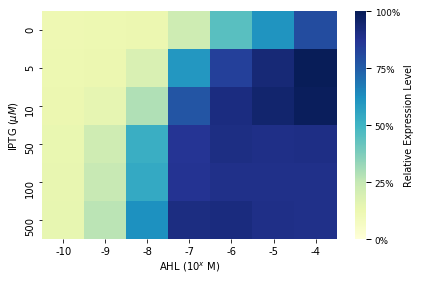

In [12]:
f, ax = plt.subplots()

make_heatmap(lx,ax,cmap='YlGnBu')

f.tight_layout()

In [13]:
R =[]
for i, fam in zip(mfi.IPTG.unique(),mfi.Family.unique()):
    tmp = mfi[(mfi.IPTG ==i) & (mfi.Family == fam)]['FITC-A'].max()/mfi[(mfi.IPTG ==i) & (mfi.Family == fam)]['FITC-A'].min()
    R.append([i,fam,tmp])
R = pd.DataFrame(R,columns=['IPTG','Family','Induction Ratio'])

In [14]:
Lux = Data[Data.Family=='LuxR']
Lux

,FITC-A,AHL,IPTG,Family,Replicate,logAHL
5852,7367.249863,0.0001,0,LuxR,1,-4
5853,8199.399765,0.0001,0,LuxR,1,-4
5854,5718.970078,0.0001,0,LuxR,1,-4
5855,6753.149765,0.0001,0,LuxR,1,-4
5856,9613.609726,0.0001,0,LuxR,1,-4
5857,7251.549667,0.0001,0,LuxR,1,-4
5858,6936.490097,0.0001,0,LuxR,1,-4
5859,5674.470078,0.0001,0,LuxR,1,-4
5860,6498.609726,0.0001,0,LuxR,1,-4
5861,9313.680038,0.0001,0,LuxR,1,-4


In [15]:
def plot_hill(median_fluorescence,standard_deviation,IPTG_range,colormap,ax=None,  **kwargs):
    """
    This is a function to generate Hill plots
    
    Args:
        median_fluorescence (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        
        standard_deviation (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry standard deviation of fluorescence intensity (mfi)
        
        IPTG_range (list)
        List of IPTG values to plot
        
        colormap (str)
        Name of colormap to use
        
        ax (plt.ax)
        Axis to plot data on
        
        **kwargs
        Addition arguments to pass to sns.heatmap
    """
    sns.set_context('paper')
    ax = ax or plt.gca()
    lines = []  
    fits = pd.DataFrame(columns=['AHL','FITC-A','IPTG'])
    cmap = matplotlib.cm.get_cmap(colormap)
    colors = cmap(np.linspace(0,1,len(IPTG_range)))
    for i,iptg in enumerate(IPTG_range):
        mean = median_fluorescence[(median_fluorescence.IPTG==iptg) & (median_fluorescence.logAHL != 0)]
        std = standard_deviation[(standard_deviation.IPTG==iptg) & (standard_deviation.logAHL != 0)]
        ax.errorbar(x=mean.logAHL.values,y=mean['FITC-A'].values,yerr=std['FITC-A'].values,color=colors[i],capsize=5,ls='',marker='o')
        def func(x, a, b):
            return (mean['FITC-A'].max() -mean['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + mean['FITC-A'].min()
        (a_, b_), _ = opt.curve_fit(func, mean.AHL, mean['FITC-A'],p0=[1,1e-9],maxfev=10000000)
        n = 1e6
        x = np.linspace(mean.AHL.min(), mean.AHL.max(), int(n))
        y_fit = func(x, a_, b_)
        fits=fits.append(pd.DataFrame(np.concatenate([[x], [y_fit],[np.ones(len(x))*iptg]]).T,columns=['AHL','FITC-A','IPTG']),ignore_index=True)
        lines2, =ax.plot(np.log10(x), y_fit, '-',color = colors[i],label='IPTG {:.1f} fit'.format(iptg))
        lines += ax.plot(mean.logAHL.values, mean['FITC-A'].values, 'o',color = colors[i],label=r'IPTG {} $\mu M$'.format(iptg))

    labels = [l.get_label() for l in lines]
    #labels = ax.get_labels()
    ax.legend(handles=lines,labels=labels,frameon=False)
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel(r'mNG Intensity (au)')
    sns.despine()
    return ax
  

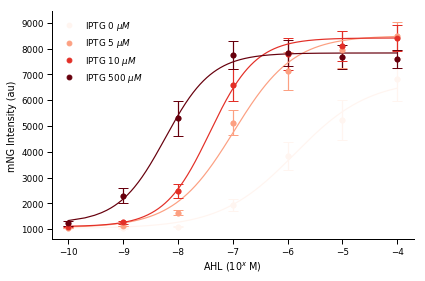

In [16]:
f, ax = plt.subplots()
colors = ['#a1dab4','#41b6c4','#2c7fb8','#253494']
plot_hill(mfi,std,[0,5,10,500],'Reds',ax)


f.tight_layout()

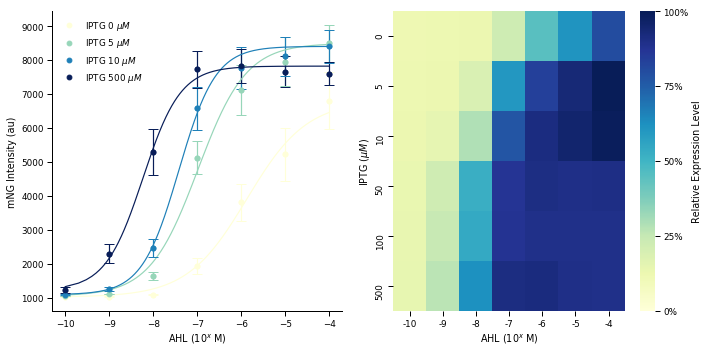

In [17]:
f, axes = plt.subplots(ncols=2,figsize=(10,5))
plot_hill(mfi,std,[0,5,10,500],'YlGnBu',axes[0])
make_heatmap(lx,axes[1],cmap='YlGnBu')
f.tight_layout()

In [18]:
def plot_hill_ratio(median_fluorescence,standard_deviation,IPTG_range,colormap,ax=None,  **kwargs):
    """
    This is a function to generate Hill plots
    
    Args:
        median_fluorescence (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        
        standard_deviation (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry standard deviation of fluorescence intensity (mfi)
        
        IPTG_range (list)
        List of IPTG values to plot
        
        colormap (str)
        Name of colormap to use
        
        ax (plt.ax)
        Axis to plot data on
        
        **kwargs
        Addition arguments to pass to sns.heatmap
    """
    sns.set_context('paper')
    ax = ax or plt.gca()
    lines = []  
    fits = pd.DataFrame(columns=['AHL','FITC-A','IPTG'])
    cmap = matplotlib.cm.get_cmap(colormap)
    colors = cmap(np.linspace(0,1,len(IPTG_range)))
    
    R =[]
    for i in mean.IPTG.unique():
        tmp = mean[mean.IPTG ==i]['FITC-A'].max()/mean[mean.IPTG ==i]['FITC-A'].min()
        R.append([i,tmp])
    R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])
    for i,iptg in enumerate(IPTG_range):
        mean = median_fluorescence[(median_fluorescence.IPTG==iptg) & (median_fluorescence.logAHL != 0)]
        mean['FITC-A'].max()
        mean['FITC-A'].min()
        #std = standard_deviation[(standard_deviation.IPTG==iptg) & (standard_deviation.logAHL != 0)]
        #ax.errorbar(x=mean.logAHL.values,y=mean['FITC-A'].values,yerr=std['FITC-A'].values,color=colors[i],capsize=5,ls='',marker='o')
        def func(x, a, b):
            return ( -) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + mean['FITC-A'].min()
        (a_, b_), _ = opt.curve_fit(func, mean.AHL, mean['FITC-A'],p0=[1,1e-9],maxfev=10000000)
        n = 1e6
        x = np.linspace(mean.AHL.min(), mean.AHL.max(), int(n))
        y_fit = func(x, a_, b_)
        fits=fits.append(pd.DataFrame(np.concatenate([[x], [y_fit],[np.ones(len(x))*iptg]]).T,columns=['AHL','FITC-A','IPTG']),ignore_index=True)
        lines2, =ax.plot(np.log10(x), y_fit, '-',color = colors[i],label='IPTG {:.1f} fit'.format(iptg))
        lines += ax.plot(mean.logAHL.values, mean['FITC-A'].values, 'o',color = colors[i],label=r'IPTG {} $\mu M$'.format(iptg))

    labels = [l.get_label() for l in lines]
    #labels = ax.get_labels()
    ax.legend(handles=lines,labels=labels,frameon=False)
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel(r'mNG Intensity (au)')
    sns.despine()
    return ax

SyntaxError: invalid syntax (<ipython-input-18-3aa13626d96c>, line 43)

In [ ]:
mfi_rep = Data.groupby(['IPTG','Family','logAHL','Replicate']).median().reset_index()
mfi_rep['R'] = mfi_rep.groupby(['Family','IPTG','Replicate'])['FITC-A'].transform(lambda x: x.max()/x.min())

<AxesSubplot:xlabel='IPTG', ylabel='R'>

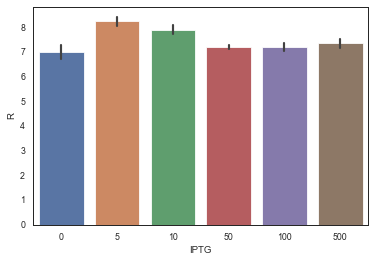

In [ ]:
sns.barplot(x='IPTG',y='R',data=mfi_rep)

In [ ]:
mfi

,IPTG,Family,logAHL,FITC-A,AHL
0,0,LuxR,-10,1028.719955,1.000000e-10
1,0,LuxR,-9,1041.920029,1.000000e-09
2,0,LuxR,-8,1099.999985,1.000000e-08
3,0,LuxR,-7,1945.680038,1.000000e-07
4,0,LuxR,-6,3823.599960,1.000000e-06
5,0,LuxR,-5,5230.720078,1.000000e-05
6,0,LuxR,-4,6811.200058,1.000000e-04
7,0,LuxR,0,1098.979965,0.000000e+00
8,5,LuxR,-10,1058.639999,1.000000e-10
9,5,LuxR,-9,1125.520004,1.000000e-09


C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas

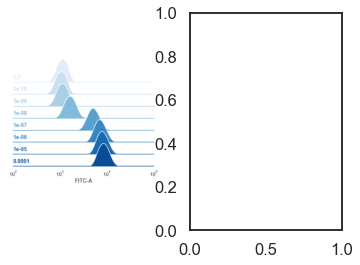

In [ ]:
def ridgeplot(data,iptg,colormap,ax=None):
    ax = ax or plt.gca()
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    sns.set_context('talk')
    tmpdf = Data[Data.IPTG==iptg][['AHL','FITC-A']]
    #print('IPTG=' +str(I))
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=10, height=.75, palette=colormap)#
    #g.set(xlim=(0, 20000))
    # Draw the densities in a few steps
    g.map(sns.kdeplot, "FITC-A", clip_on=True, shade=True, alpha=1, lw=1,log_scale=True,bw_adjust=3)
    g.map(sns.kdeplot, "FITC-A", clip_on=True, color="w", lw=2,log_scale=True,bw_adjust=3)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
        #ax.set_xlim(1e2,2e5)
    g.set(xlim=(1e2,1e5))
    g.map(label, "FITC-A")
    #if I ==0.001:
    #    g.map(label, "FITC-A")
    #else:
     #   g.map(label, "FITC-A")
     #   for ax in g.axes.flat:
     #       ax.set_axis_off()
      #  g.set(xticks=[])

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.savefig('ridge.png')
    plt.close(g.fig)
    
    return ax.imshow(mpimg.imread('ridge.png'))
f, axes = plt.subplots(ncols=2)
ridgeplot(data=Data[Data.Family=='LuxR'],iptg=5,colormap='Blues',ax=axes[0])
axes[0].set_axis_off()

C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\envs\cf\lib\site-packages\pandas

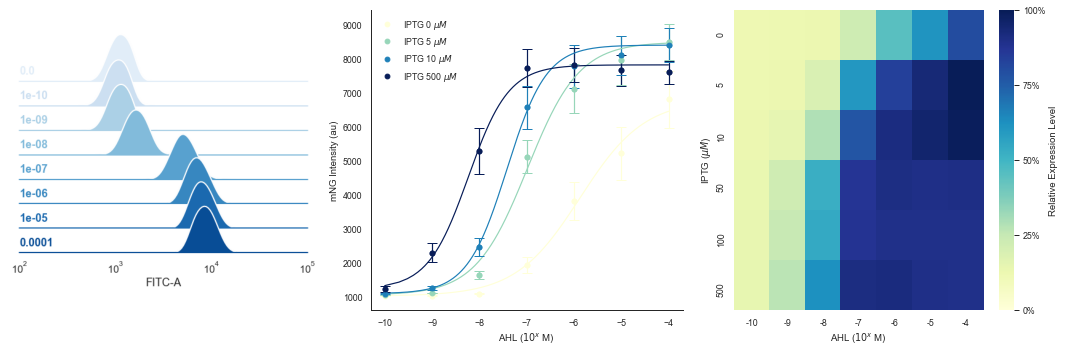

In [ ]:
f, axes = plt.subplots(ncols=3,figsize=(15,5))
ridgeplot(data=Data[Data.Family=='LuxR'],iptg=5,colormap='Blues',ax=axes[0])
axes[0].set_axis_off()
plot_hill(mfi,std,[0,5,10,500],'YlGnBu',axes[1])
make_heatmap(lx,axes[2],cmap='YlGnBu')
f.tight_layout()

IPTG=0


C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jonathan\AppData\Roaming

IPTG=5


C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\J

IPTG=10


C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming

IPTG=50


C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jonathan\AppData\Roaming

IPTG=100


C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\J

IPTG=500


C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\J

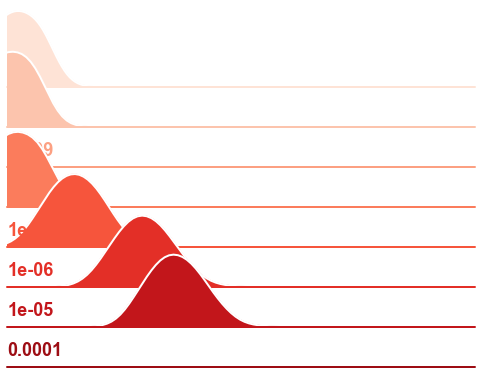

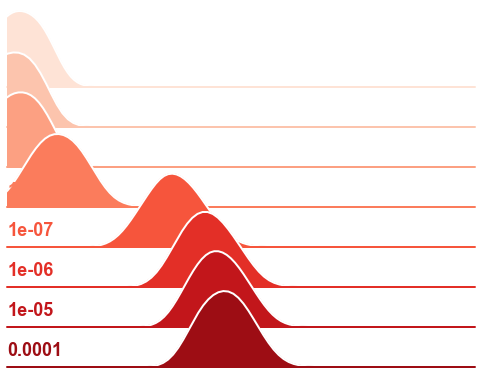

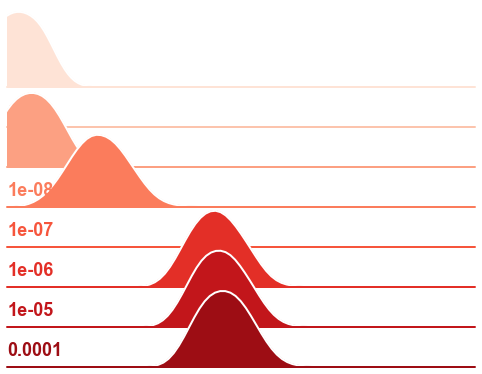

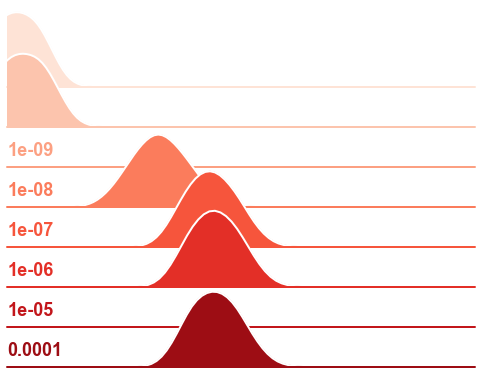

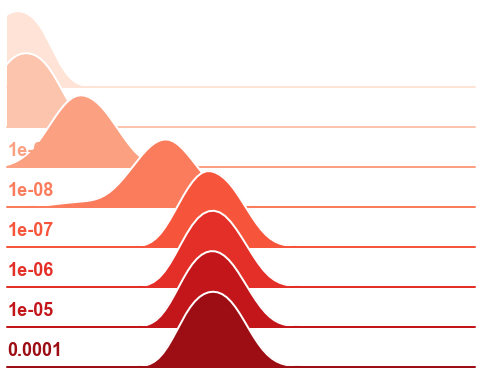

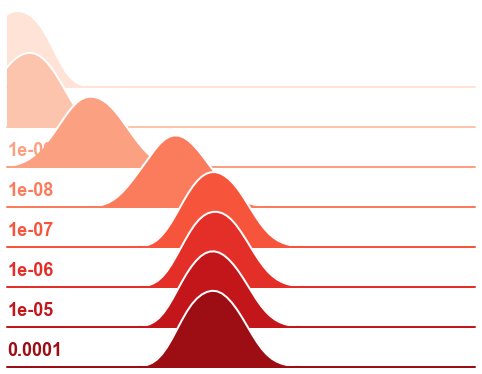

In [ ]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context('talk')
for I in data.IPTG.unique():
    tmpdf = data[data.IPTG==I][['AHL','FITC-A']]
    print('IPTG=' +str(I))
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=10, height=.75, palette='Reds')#
    #g.set(xlim=(0, 20000))
    # Draw the densities in a few steps
    g.map(sns.kdeplot, "FITC-A", clip_on=True, shade=True, alpha=1, lw=1,log_scale=True,bw_adjust=3)
    g.map(sns.kdeplot, "FITC-A", clip_on=True, color="w", lw=2,log_scale=True,bw_adjust=3)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
        #ax.set_xlim(1e2,2e5)
    g.set(xlim=(1e3,1e5))

    if I ==0.001:
        g.map(label, "FITC-A")
    else:
        g.map(label, "FITC-A")
        for ax in g.axes.flat:
            ax.set_axis_off()
        g.set(xticks=[])

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    #plt.show()
    #g.savefig('Ridge_Las_IPTG {:.1e}.pdf'.format(I))
